In [2]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn-v0_8')
# plt.style.use('seaborn-colorblind') #alternative
# plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

# Study on Bitcoin Volatility

First of all I've already have the data I downloaded in the data loading notebook, so we start by loading that

In [3]:
df_btc = pd.read_csv("/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_data_vol_OI.csv")
df_btc.head()

,startTime,openPrice,highPrice,lowPrice,closePrice,symbol,volume,turnover,openInterest
0,2024-04-30,63846.04,64724.78,59089.54,60632.64,BTCUSD,2117478141,34765.045310,331760650.0
1,2024-04-29,63109.42,64191.68,61771.95,63846.04,BTCUSD,1330431186,21244.648750,317626466.0
2,2024-04-28,63433.42,64340.59,62767.71,63109.42,BTCUSD,698842508,10994.505878,316996638.0
3,2024-04-27,63751.61,63907.37,62397.63,63433.42,BTCUSD,912937699,14488.390121,318241311.0
4,2024-04-26,64488.03,64791.93,63308.59,63751.61,BTCUSD,1148931440,17931.562023,319516725.0


In this section I want to study the volatility, in particular the correlation between my **close price** and the **VIX** index.

To do so I need to download the VIX for BTC from the API:

In [4]:
from pybit.unified_trading import HTTP
session = HTTP(testnet=True)
print(session.get_historical_volatility(
    category="option",
    baseCoin="BTC",
    period=30,
))

{'retCode': 0, 'retMsg': 'SUCCESS', 'category': 'option', 'result': [{'period': 30, 'value': '0.54694103', 'time': '1715842800000'}]}


Like last time, I need to use the start and end date in timestamps

In [9]:
import datetime

def convert_to_timestamp(date_time_str):
    # List of expected date and time formats, from most specific to least specific
    formats = [
        '%Y-%m-%d %H:%M:%S',  # Complete date and time
        '%Y-%m-%d %H:%M',     # Date and time without seconds
        '%Y-%m-%d %H',        # Date and hour only
        '%Y-%m-%d'            # Date only
    ]
    
    # Try parsing the date_time string using the expected formats
    for fmt in formats:
        try:
            date_time_obj = datetime.datetime.strptime(date_time_str, fmt)
            # Convert datetime object to timestamp (in seconds)
            timestamp = int(date_time_obj.timestamp())
            # Convert to milliseconds and ensure it is a 13-digit number
            timestamp_milliseconds = timestamp * 1000
            return '{:013d}'.format(timestamp_milliseconds)
        except ValueError:
            continue
    
    # Raise an error if no format matches
    raise ValueError("Date and time format is incorrect or unsupported.")


start_date = convert_to_timestamp("2024-04-01")
end_date = convert_to_timestamp("2024-5-1")

Sadly the API can be queried only for 30 days, so we do only April2024

In [27]:
from pybit.unified_trading import HTTP
session = HTTP(testnet=True)
symbol = "BTC"
data = session.get_historical_volatility(
    category="option",
    baseCoin=symbol,
    period=30,
    startTime = start_date,
    endTime = end_date,
)


# Convert list to DataFrame
columns = ["period", "value", "time"]#, 'volume', 'turnover']
df = pd.DataFrame(data["result"], columns=columns)

# Adding a new column for the symbol
df['symbol'] = symbol

# Convert startTime to datetime and prices to floats
df['startTime'] = pd.to_datetime(df['time'].astype(float), unit='ms')

# Sort the DataFrame by startTime in descending order
df = df.sort_values(by='startTime', ascending=False)
# Drop the 'time' and 'period' columns

df = df.drop(columns=['time', 'period'])

# Display the DataFrame
print(df)

          value symbol           startTime
720  0.58418179    BTC 2024-04-30 15:00:00
719  0.58371678    BTC 2024-04-30 14:00:00
718  0.58326688    BTC 2024-04-30 13:00:00
717  0.58328617    BTC 2024-04-30 12:00:00
716  0.58248651    BTC 2024-04-30 11:00:00
..          ...    ...                 ...
4    0.65260509    BTC 2024-03-31 19:00:00
3    0.65243071    BTC 2024-03-31 18:00:00
2    0.65287710    BTC 2024-03-31 17:00:00
1    0.65341521    BTC 2024-03-31 16:00:00
0    0.65342054    BTC 2024-03-31 15:00:00

[721 rows x 3 columns]


Right now we have hourly data, so for the sake of this analysis I will also redownload hourly hours for the same interval of time in the market data for BTC. The old data was actually a daily one so let's go!

In [34]:
from pybit.unified_trading import HTTP
session = HTTP(testnet=True)

symbol = "BTCUSD"
category = "linear"

print(session.get_kline(
    category=category,
    symbol=symbol,
    interval="60",
    start = start_date,
    end = end_date,
    limit=200,
))

data_volume = session.get_kline(
    category=category,
    symbol=symbol,
    interval="60",
    start = start_date,
    end = end_date,
    limit=200,
)


# Convert list to DataFrame
columns = ['startTime', 'openPrice', 'highPrice', 'lowPrice', 'closePrice', 'volume', 'turnover']
df2 = pd.DataFrame(data_volume["result"]['list'], columns=columns)


# Convert startTime to datetime and prices to floats
df2["symbol"] = symbol
df2['startTime'] = pd.to_datetime(df2['startTime'].astype(float), unit='ms')
for col in ['openPrice', 'highPrice', 'lowPrice', 'closePrice']:
    df2[col] = df2[col].astype(float)

df2["symbol"] = symbol
# Sort the DataFrame by startTime in descending order
df2 = df2.sort_values(by='startTime', ascending=False)

# Display the DataFrame
print(df2)

{'retCode': 0, 'retMsg': 'OK', 'result': {'symbol': 'BTCUSD', 'category': 'linear', 'list': [['1714489200000', '61177.5', '61334', '60530.5', '60724', '117661867', '1933.79354478'], ['1714485600000', '60776.5', '61482', '60531', '61177.5', '123668091', '2030.09821028'], ['1714482000000', '61190', '145950.5', '21478', '60776.5', '158239656', '2835.06028099'], ['1714478400000', '61138', '61284', '60695.5', '61190', '110596422', '1809.99633058'], ['1714474800000', '61731.5', '61732.5', '61004', '61138', '99544414', '1623.39000911'], ['1714471200000', '61646', '61731.5', '61471.5', '61731.5', '69341063', '1125.16987197'], ['1714467600000', '61868.5', '62078', '61590.5', '61646', '103995445', '1681.91323937'], ['1714464000000', '63100', '63202.5', '61766.5', '61868.5', '133581696', '2139.95295126'], ['1714460400000', '63350.5', '63410', '63100', '63100', '34358711', '543.05891015'], ['1714456800000', '63295.5', '63400.5', '58646.5', '63350.5', '30165195', '477.17378292'], ['1714453200000', 

Let me clean a moment since I just need the close price and the data

In [49]:
df_btc = df2[["startTime", "closePrice", "volume", "symbol"]]
df_btc.rename(columns = {"symbol":"Crypto Pair"}, inplace=True)
df_btc.head()

/var/folders/97/gnjvmb3x0_s4v_gfyqxc1zdm0000gn/T/ipykernel_96321/2374557663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_btc.rename(columns = {"symbol":"Crypto Pair"}, inplace=True)


,startTime,closePrice,volume,Crypto Pair
0,2024-04-30 15:00:00,60724.0,117661867,BTCUSD
1,2024-04-30 14:00:00,61177.5,123668091,BTCUSD
2,2024-04-30 13:00:00,60776.5,158239656,BTCUSD
3,2024-04-30 12:00:00,61190.0,110596422,BTCUSD
4,2024-04-30 11:00:00,61138.0,99544414,BTCUSD


In [50]:
df.head()

,value,symbol,startTime
720,0.58418179,BTC,2024-04-30 15:00:00
719,0.58371678,BTC,2024-04-30 14:00:00
718,0.58326688,BTC,2024-04-30 13:00:00
717,0.58328617,BTC,2024-04-30 12:00:00
716,0.58248651,BTC,2024-04-30 11:00:00


Let's merge to proceed and imma save it

In [51]:
df_volatility = pd.merge(df_btc, df, on='startTime', how='inner')
df_volatility.rename(columns = {"value":"VIX"}, inplace=True)

for col in ['closePrice', 'VIX', 'volume']:
    df_volatility[col] = df_volatility[col].astype(float)

df_volatility.head()

,startTime,closePrice,volume,Crypto Pair,VIX,symbol
0,2024-04-30 15:00:00,60724.0,117661867.0,BTCUSD,0.584182,BTC
1,2024-04-30 14:00:00,61177.5,123668091.0,BTCUSD,0.583717,BTC
2,2024-04-30 13:00:00,60776.5,158239656.0,BTCUSD,0.583267,BTC
3,2024-04-30 12:00:00,61190.0,110596422.0,BTCUSD,0.583286,BTC
4,2024-04-30 11:00:00,61138.0,99544414.0,BTCUSD,0.582487,BTC


In [52]:
df_volatility.to_csv('/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_btc_volatility.csv', index=False) 

In [53]:
df_volatility['log_rtn'] = np.log(df_volatility.closePrice / df_volatility.closePrice.shift(1)) 
df_volatility['vol_rtn'] = np.log(df_volatility.VIX / df_volatility.VIX.shift(1))

df_volatility.dropna(how='any', axis=0, inplace=True)

In [54]:
df_volatility.head()

,startTime,closePrice,volume,Crypto Pair,VIX,symbol,log_rtn,vol_rtn
1,2024-04-30 14:00:00,61177.5,123668091.0,BTCUSD,0.583717,BTC,0.007440,-7.963192e-04
2,2024-04-30 13:00:00,60776.5,158239656.0,BTCUSD,0.583267,BTC,-0.006576,-7.710477e-04
3,2024-04-30 12:00:00,61190.0,110596422.0,BTCUSD,0.583286,BTC,0.006781,3.307179e-05
4,2024-04-30 11:00:00,61138.0,99544414.0,BTCUSD,0.582487,BTC,-0.000850,-1.371897e-03
5,2024-04-30 10:00:00,61731.5,69341063.0,BTCUSD,0.582487,BTC,0.009661,6.867109e-07


[Text(0.5, 1.0, 'BTC vs. VIX ($\\rho$ = 0.06)'),
 Text(0.5, 0, 'BTC log returns')]

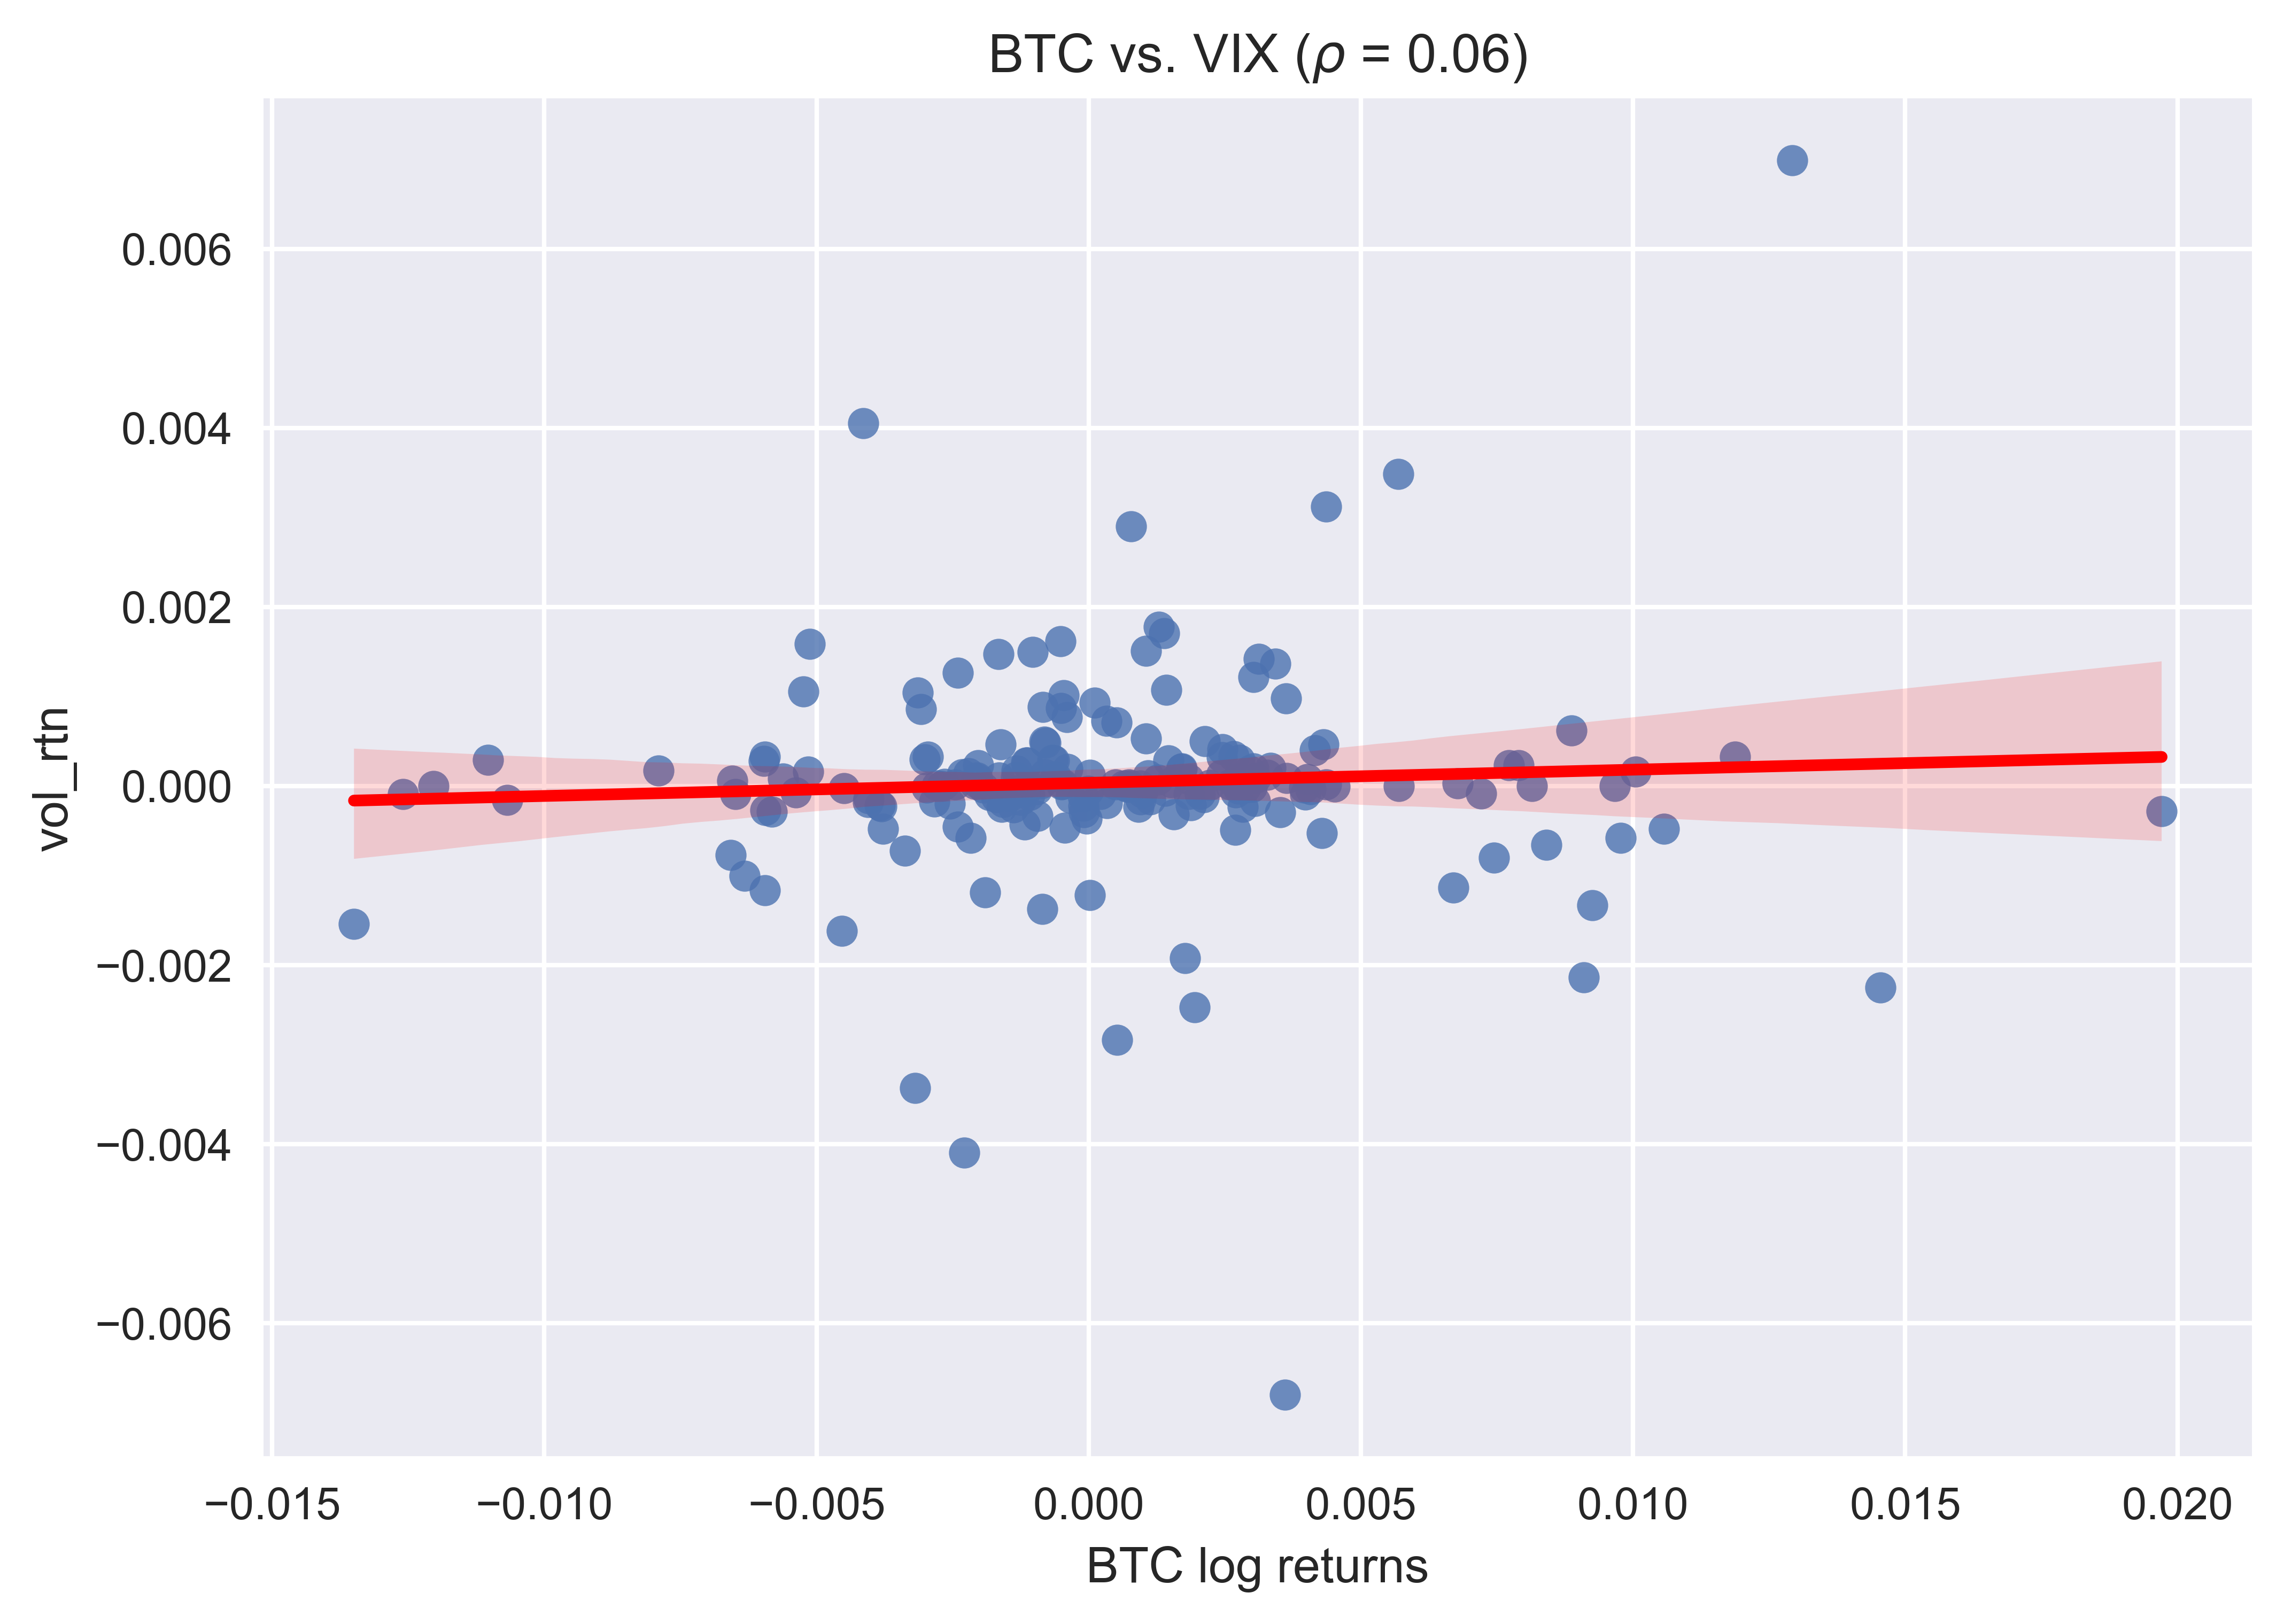

In [57]:
import seaborn as sns

corr_coeff = df_volatility.log_rtn.corr(df_volatility.vol_rtn)

ax = sns.regplot(x='log_rtn', y='vol_rtn', data=df_volatility, line_kws={'color': 'red'})

ylabel='VIX log returns',

ax.set(title=f'BTC vs. VIX ($\\rho$ = {corr_coeff:.2f})',

xlabel='BTC log returns')

Correlation is basically zero here so there is not much leverage effect. It might be since BTC is in bull run and April was generally consolidation.